In [2]:
import numpy as np

# 假设有 3 台机器和 3 个操作
m = 3  # 机器数量
N = 2  # 表示机器的二进制 (0, 1)
n = 3  # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[3, 1, 3], [2, 3, 1], [1, 3, 2]])

b = np.array([[0, 0], [1, 0], [0, 1]])
# 非法数组(用于表示机器数)(1, 1)
bw = np.array([[1, 1]])
# 常数
K1 = 100
P = 30
# print(len(bw))
# 量子比特数量
num_qubits = n * N + l

In [3]:
def append_multi_rzz_term(qc, qubits, gamma):
    """
    构建一个类RZZ门，n-1个控制位，1个目标位，进行旋转操作。
    参数:
    control_qubits: List[int]，控制量子比特的索引
    target_qubit: int，目标量子比特的索引
    """
    # if len(qubits)==1:
    #     qc.rz(gamma, qubits[0])
    # else:
    #     control_qubits = qubits[:N-1]
    #
    #     target_qubit = qubits[N-1:]
    #
    #     n_controls = len(control_qubits)
    #     if n_controls == 1:
    #         qc.cx(control_qubits[0],target_qubit[0])
    #     else:
    #         qc.mcx(control_qubits, target_qubit[0])
    #     qc.rz(gamma, target_qubit[0])
    #     if n_controls == 1:
    #         qc.cx(control_qubits[0], target_qubit[0])
    #     else:
    #         qc.mcx(control_qubits, target_qubit[0])
    """
    实现多体 Z 相互作用项 e^{-i \gamma Z_1 Z_2 \dots Z_k}.
    """
    if len(qubits) == 1:
        qc.rz(2 * gamma, qubits[0])
        return

    # 链式 CNOT 到最后一个量子比特
    for q in qubits[:-1]:
        qc.cx(q, qubits[-1])

    # 应用 RZ 门
    qc.rz(2 * gamma, qubits[-1])

    # 恢复链式 CNOT
    for q in reversed(qubits[:-1]):
        qc.cx(q, qubits[-1])

In [4]:
def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [5]:
def get_cost_circuit1(gamma, qc):
    for h in range(l):
        coef = - 2 ** h
        append__z_term(qc, N * n + h, coef * gamma)
    return qc

\begin{align}K_{1} \sum_{j\in W} \sum_{i=0}^{n}\prod_{k=0}^{N}\left(\frac{1}2+\left(\frac{1}2-b_{j k}\right)Z_{ik}\right)\end{align}

In [6]:
import itertools


def get_cost_circuit2(gamma, qc):
    # print(len(bw))
    if len(bw) == 0:
        return qc
    all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
    for j in range(len(bw)):
        for i in range(n):
            constant = 1 / (2 ** N)  # 系数 1/2^N  
            for qubit_indices in all_combinations:  # 遍历各种组合
                qubits_index = np.array([], dtype=int)
                # 根据组合项生成子项的常数和qubit索引
                for k in range(N):
                    constant *= (1 - 2 * bw[j, k]) if k in qubit_indices else 1
                    if k in qubit_indices:
                        qubits_index = np.append(qubits_index, i * N + k)
                # print("qubits_index", qubits_index)
                append_multi_rzz_term(qc, qubits_index, 2 * K1 * constant * gamma)
    return qc


In [7]:
# from qiskit import Aer, QuantumCircuit, execute
# gamma= 1
# qc = QuantumCircuit(num_qubits, num_qubits)
# # qc.h(range(num_qubits))
# # print(qc)
# get_cost_circuit2(gamma, qc)
# print(qc)
# qc.decompose().draw('mpl')

\begin{align}\sum_{j=0}^{m-1}\sum_{i=0}^{n-1} \sum_{i^{\prime}=0}^{n-1}\left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j}\left(\prod_{k^{\prime}=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i^{\prime} k^{\prime}}\right)\right) p_{i^{\prime} j}\end{align}
\begin{align}-2 \sum_{j=0}^{m-1} \sum_{i=0}^{n-1} \sum_{h=0}^{l-1} \left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j} \cdot 2^{h-1}\left(1-Z_h\right)\end{align}
\begin{align}\sum_{j=0}^{m-1}\sum_{h=0}^{l-1} \sum_{h^{\prime}=0}^{l-1} 2^{h-1} 2^{h^{\prime}-1}\left(1-Z_h-Z_{h^{\prime}}+Z_h Z_{h^{\prime}}\right)\end{align}

In [8]:
# import itertools
from collections import Counter


def get_cost_circuit3(gamma, qc):
    for j in range(len(b)):
        # 对应12, 13, 23, 45, 46, 56
        for i in range(n):  # 自身内部相乘，对应12, 13, 23, 45, 46, 56
            all_combinations_1 = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
            # 获取 all_combinations_1 中任意两项的所有组合
            all_two_combinations = list(itertools.combinations(all_combinations_1, 2))
            for qubit_indices in all_two_combinations:  # 遍历各种组合
                # print("qubit_indices", qubit_indices)
                # sub_constant = constant
                qubits_index = np.array([], dtype=int)
                constant = 1
                # 将组合对中的每个元素（每个元素本身也是一个组合）放入数组
                for combo in qubit_indices:  # qubit_indices: ((0,), (1,))
                    for k in combo:  # combo: (0,)
                        constant = constant * (1 - 2 * b[j, k])
                        qubits_index = np.append(qubits_index, i * N + k)
                    # 将组合项中的所有元素添加到 qubits_index 中
                # 剔除出现偶次数的项，奇次数的项保留一个

                count = Counter(qubits_index)
                # 仅保留出现次数为奇数的元素一次
                qubits_index = [x for x in count if count[x] % 2 != 0]
                # print("qubits_index", qubits_index)
                constant = 1 / (2 ** (2 * N)) * constant * p[i, j] * p[i, j]
                append_multi_rzz_term(qc, qubits_index, 2 * P * constant * gamma)

        # 2，对应14, 15, 16, 24, 25, 26, 34, 35, 36
        all_combinations_1 = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
        all_combinations_2 = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
        for i1 in range(n - 1):  # 自身内部相乘，对应14, 15, 16, 24, 25, 26, 34, 35, 36
            for i2 in range(i1 + 1, n):  # 自身内部相乘，对应23, 45, 46, 56
                for qubit_indices_1 in all_combinations_1:
                    # print("qubit_indices1", qubit_indices_1)
                    for qubit_indices_2 in all_combinations_2:
                        # print("qubit_indices2", qubit_indices_2)
                        qubits_index = np.array([], dtype=int)
                        constant = 1
                        for k1 in qubit_indices_1:  # qubit_indices: ((0,), (1,))
                            constant = constant * (1 - 2 * b[j, k1])
                            qubits_index = np.append(qubits_index, i1 * N + k1)
                        for k2 in qubit_indices_2:  # qubit_indices: ((0,), (1,))
                            constant = constant * (1 - 2 * b[j, k2])
                            qubits_index = np.append(qubits_index, i2 * N + k2)
                        constant = 1 / (2 ** (2 * N)) * constant * p[i1, j] * p[i2, j]
                        # print("qubits_index", qubits_index)
                        append_multi_rzz_term(qc, qubits_index, 2 * P * constant * gamma)

        # 对应01,02,03,74,75,76
        all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
        for i1 in range(n):  # 取常数 1 固定一个为 p[i_1, j]
            for i2 in range(n):  # 取 Z 的下标 Z_i2k
                for qubit_indices in all_combinations:  # 取 排列组合
                    qubits_index = np.array([], dtype=int)
                    constant = 1
                    for k in qubit_indices:
                        constant = constant * (1 - 2 * b[j, k])
                        qubits_index = np.append(qubits_index, i2 * N + k)
                    constant = 1 / (2 ** (2 * N)) * constant * p[i1, j] * p[i2, j]
                    # print("qubits_index", qubits_index)
                    append_multi_rzz_term(qc, qubits_index, 2 * P * constant * gamma)

        all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
        for i in range(n):
            constant = 1 / (2 ** N) * p[i, j]  # 系数
            constant1 = constant
            for qubit_indices in all_combinations:  # 遍历各种组合
                qubits_index = np.array([], dtype=int)
                # 根据组合项生成子项的常数和qubit索引
                for k in range(N):
                    constant1 *= (1 - 2 * b[j, k]) if k in qubit_indices else 1
                    if k in qubit_indices:
                        qubits_index = np.append(qubits_index, i * N + k)
                # print("qubits_index", qubits_index)
                constant1 = constant1 * (2 ** (l - 1)) * (-2)
                append_multi_rzz_term(qc, qubits_index, 2 * P * constant1 * gamma)
            constant2 = constant
            for h in range(l):
                for qubit_indices in all_combinations:  # 遍历各种组合
                    qubits_index = np.array([], dtype=int)
                    # 根据组合项生成子项的常数和qubit索引
                    for k in range(N):
                        constant2 *= (1 - 2 * b[j, k]) if k in qubit_indices else 1
                        if k in qubit_indices:
                            qubits_index = np.append(qubits_index, i * N + k)
                    # print("qubits_index", qubits_index)
                    qubits_index = np.append(qubits_index, n * N + h)
                    constant2 = constant2 * (2 ** (h - 1)) * (-2)
                    append_multi_rzz_term(qc, qubits_index, 2 * P * constant2 * gamma)

        for h1 in range(l):  # 遍历 h 的范围
            for h2 in range(l):  # 遍历 h' 的范围
                coef = 2 ** (h1 - 1) * 2 ** (h2 - 1)  # 计算系数权重

                # -Z_h1 项
                append__z_term(qc, n * N + h1, 2 * P * coef * gamma)

                # -Z_h2 项
                append__z_term(qc, n * N + h2, 2 * P * coef * gamma)

                # Z_h1 Z_h2 项
                if h1 != h2:  # 避免重复
                    append__zz_term(qc, n * N + h1, n * N + h2, 2 * P * coef * gamma)




In [9]:
# from qiskit import Aer, QuantumCircuit, execute
# gamma= 1
# qc = QuantumCircuit(num_qubits, num_qubits)
# get_cost_circuit3(gamma, qc)
# print(qc)
# qc.decompose().draw('mpl')

In [10]:
# from qiskit import Aer, QuantumCircuit, execute
# gamma= 1
# qc = QuantumCircuit(num_qubits, num_qubits)
# # qc.h(range(num_qubits))
# # print(qc)
# get_cost_circuit4(gamma, qc)
# # print(qc)
# # qc.decompose().draw('mpl')

In [11]:
def get_mixer_circuit(beta, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
    return qc

In [12]:
def invert_counts(s):
    return s[::-1]

In [13]:
from qiskit import Aer, QuantumCircuit, execute


# 定义成本函数
def cost_function(params):
    beta, gamma = params[:len(params) // 2], params[len(params) // 2:]
    num_qubits = n * N + l
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    # print(qc)

    length = len(params)
    for i in range(int(length / 2)):
        get_cost_circuit1(gamma[i], qc)
        get_cost_circuit2(gamma[i], qc)
        get_cost_circuit3(gamma[i], qc)
        get_mixer_circuit(beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
        s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = 0
        for j in range(len(bw)):
            for i in range(n):
                constant = 1
                for k in range(N):
                    constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
                E2 += constant
        E2 = K1 * E2
        E3 = 0
        for j in range(m):
            constant1 = 0
            for i in range(n):
                constant2 = 1
                for k in range(N):
                    constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
                constant1 += p[i, j] * constant2
            constant3 = 0
            for h in range(l):
                constant3 += 2 ** h * z_h[h]
            constant = max(0, constant1 - constant3)
            E3 += P * (constant) ** 2

        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

        E = E1 + E2 + E3

        expectation += E * prob

    return expectation, counts

In [14]:
from qiskit_algorithms.optimizers import COBYLA


# 优化 QAOA 参数
def optimize_qaoa(params):
    def objective(params):
        expectation, _ = cost_function(params)

        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-8)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [15]:
# 傅里叶参数化初始化
def fourier_initial_params(p, q=1, amplitude=0.1):
    """生成基于傅里叶级数的初始参数"""
    t = np.linspace(0, 1, p)
    beta = np.zeros(p)
    gamma = np.zeros(p)
    for k in range(1, q + 1):
        beta += (np.random.uniform(0, amplitude) * np.cos(2 * np.pi * k * t) +
                 np.random.uniform(0, amplitude) * np.sin(2 * np.pi * k * t))
        gamma += (np.random.uniform(0, amplitude) * np.cos(2 * np.pi * k * t) +
                  np.random.uniform(0, amplitude) * np.sin(2 * np.pi * k * t))
    beta = np.clip(beta, 0, np.pi)  # 限制 β 在 [0, π]
    gamma = np.clip(gamma, 0, 2 * np.pi)  # 限制 γ 在 [0, 2π]
    return np.concatenate([beta, gamma])

In [16]:
# 主程序
import time

startTime = time.time()
min_energy = float('inf')
init_point = np.array([])
counts = {}
final_result = None

for p1 in range(1, 4):
    min_energy = 100000
    for k in range(10):
        print(f"第 {p1} 层，第 {k} 个参数")
        # 使用傅里叶方法生成初始参数
        init_point_temp = fourier_initial_params(p1, q=1, amplitude=0.5)

        result = optimize_qaoa(init_point_temp)
        optimal_params = result.x
        energy, counts_temp = cost_function(result.x)

        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
            print(f"New best energy: {min_energy}")
            print(f"Optimal parameters: {init_point}")

endTime = time.time()

第 1 层，第 0 个参数


C:\Users\李华宪\AppData\Local\Temp\ipykernel_45164\2667179906.py:21: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, seed_simulator=10, shots=10000).result()


New best energy: 283.9368999999999
Optimal parameters: [0.69045101 0.52432963]
第 1 层，第 1 个参数
第 1 层，第 2 个参数
第 1 层，第 3 个参数
第 1 层，第 4 个参数
第 1 层，第 5 个参数
第 1 层，第 6 个参数
第 1 层，第 7 个参数
第 1 层，第 8 个参数
第 1 层，第 9 个参数
第 2 层，第 0 个参数
New best energy: 339.98960000000005
Optimal parameters: [2.82444286 0.87457837 0.55147217 1.64842839]
第 2 层，第 1 个参数
第 2 层，第 2 个参数
第 2 层，第 3 个参数
第 2 层，第 4 个参数
第 2 层，第 5 个参数
第 2 层，第 6 个参数
第 2 层，第 7 个参数
第 2 层，第 8 个参数
第 2 层，第 9 个参数
New best energy: 313.7031000000001
Optimal parameters: [-0.28397516 -0.11822208 -0.94332083  2.12285329]
第 3 层，第 0 个参数
New best energy: 358.6874000000001
Optimal parameters: [ 1.70228058 -0.00455404  0.59293704  0.10982703 -0.02910505 -0.03971116]
第 3 层，第 1 个参数
New best energy: 309.13100000000003
Optimal parameters: [ 0.16867001  0.29330108  0.55794931  0.04906827 -0.04833304  0.10216918]
第 3 层，第 2 个参数
第 3 层，第 3 个参数
第 3 层，第 4 个参数
第 3 层，第 5 个参数
第 3 层，第 6 个参数
第 3 层，第 7 个参数
第 3 层，第 8 个参数
第 3 层，第 9 个参数


优化时间： 416.4594712257385
Optimal parameters: [ 0.16867001  0.29330108  0.55794931  0.04906827 -0.04833304  0.10216918]
Optimal value: 309.13100000000003
Final expectation value: 309.13100000000003
Final measurement counts: {'1100101': 492, '1111101': 409, '1100111': 378, '1100001': 345, '1000001': 320, '1011011': 284, '1000101': 283, '1000011': 278, '0111111': 276, '0111001': 269, '1110011': 258, '1011111': 254, '1010001': 248, '1011101': 222, '0101001': 219, '0110011': 217, '0101111': 206, '1011001': 204, '0100111': 198, '0100001': 196, '1000111': 193, '1111111': 181, '1110111': 174, '1111011': 146, '0110111': 140, '0110001': 139, '1010011': 132, '1010111': 132, '0011101': 130, '0100011': 130, '1110001': 129, '1001011': 126, '1001010': 122, '0111101': 119, '0101011': 104}


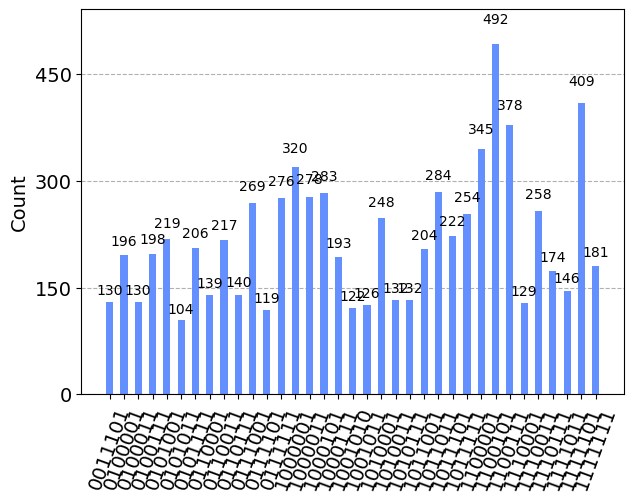

In [17]:
import warnings
from qiskit.visualization import plot_histogram

# 忽略弃用警告
warnings.filterwarnings("ignore", category=DeprecationWarning)
# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
# 过滤掉计数小于 100 的结果
filtered_dict = {key: value for key, value in sorted_dict.items() if value >= 100}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", filtered_dict)
plot_histogram(filtered_dict)

In [55]:
# 计算期望值
expectation = 0
for bitstring, count in sorted_dict.items():
    bitstring = invert_counts(bitstring)
    prob = count / 10000
    z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
    s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
    E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
    E2 = 0
    for j in range(len(bw)):
        for i in range(n):
            constant = 1
            for k in range(N):
                constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
            E2 += constant
    E2 = E2
    E3 = 0
    for j in range(m):
        constant1 = 0
        for i in range(n):
            constant2 = 1
            for k in range(N):
                constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
            constant1 += p[i, j] * constant2
        constant3 = 0
        for h in range(l):
            constant3 += 2 ** h * z_h[h]
        constant = max(0, constant1 - constant3)
        E3 += (constant) ** 2

    # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

    E = E1 + E2 + E3

    expectation += E * prob
print(expectation)

5.126100000000003


In [56]:
expectation = 0
bitstring = "1001111"
z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
E2 = 0
for j in range(len(bw)):
    for i in range(n):
        constant = 1
        for k in range(N):
            constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
        E2 += constant
E2 = K1 * E2
E3 = 0
for j in range(m):
    constant1 = 0
    # print("机器：", j)
    for i in range(n):
        constant2 = 1
        for k in range(N):
            constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
        # print("constant2:", constant2)
        # print("p[i,j]:", p[i,j])
        constant1 += p[i, j] * constant2
    # print("constant1:", constant1)
    constant3 = 0
    for h in range(l):
        constant3 += 2 ** h * z_h[h]
    # print("constant3:", constant3)
    constant = max(0, constant1 - constant3)
    E3 += (constant) ** 2

    # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

E = E1 + K1 * E2 + P * E3
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)

1
100
0
